<a href="https://colab.research.google.com/github/Parv-Agarwal/Internship-project/blob/main/Unlearning_using_GRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os

class MNISTDataset(Dataset):
    def __init__(self, file_name, max_load=None, transform=None):
        # Load the dataset from the given file
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data
        if 'train' in file_name:
            dataset = datasets.MNIST(root='./data', train=True, download=True)
        else:
            dataset = datasets.MNIST(root='./data', train=False, download=True)

        self.data = dataset.data
        self.labels = dataset.targets

        # Limit the number of examples if max_load is specified
        if max_load is not None and max_load > 0 and max_load < len(self.data):
            self.data = self.data[:max_load]
            self.labels = self.labels[:max_load]
            print(f'<mnist> loading only {max_load} examples')

        print('<mnist> done')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        # Convert tensor to PIL Image
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Return label as an integer
        return img, label


In [3]:
# dataset_mnistM.py

import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os
from torchvision import transforms

class MNISTMDataset(Dataset):
    def __init__(self, file_name, max_load=None, transform=None):
        # Load the MNIST-M dataset from the given file
        # Assuming the dataset is stored in .npy files or a custom format
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data from file_name
        # For this example, we'll assume data is stored in .pt files
        # Replace this with the actual data loading code
        if not os.path.isfile(file_name):
            raise FileNotFoundError(f"File {file_name} not found.")

        data_dict = torch.load(file_name)

        # Check if data_dict is a tuple and convert to dict if needed
        if isinstance(data_dict, tuple):
            # Assuming the tuple has data and labels in the first two positions
            self.data = data_dict[0]
            self.labels = data_dict[1]
        else:
            self.data = data_dict['data']
            self.labels = data_dict['labels']

        n_example = self.data.size(0)
        print(f'nExample {n_example}')

        # Limit the number of examples if max_load is specified
        if max_load is not None and max_load > 0 and max_load < n_example:
            n_example = max_load
            print(f'<mnistM> loading only {n_example} examples')
            self.data = self.data[:n_example]
            self.labels = self.labels[:n_example]

        print('<mnistM> done')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8))
        elif torch.is_tensor(img):
            if img.dim() == 3:
                img = img.permute(2, 0, 1)
            elif img.dim() == 2:
                img = img.unsqueeze(0)
            img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Return label as an integer
        return img, label


In [4]:
opt = {
    'dataset': 'mnist',
    'batchSize': 64,
    'loadSize': 33,
    'fineSize': 32,
    'nz': 100,               # # of dim for Z
    'ngf': 64,               # # of gen filters in first conv layer
    'ndf': 64,               # # of discrim filters in first conv layer
    'nThreads': 4,           # # of data loading threads to use
    'niter': 10000,          # # of iter at starting learning rate
    'lr': 0.0002,            # initial learning rate for adam
    'beta1': 0.5,            # momentum term of adam
    'ntrain': float('inf'),  # # of examples per epoch
    'display': 0,            # display samples while training
    'display_id': 0,         # display window id
    'gpu': 1,                # gpu = 0 is CPU mode. gpu=X is GPU mode on GPU X
    'name': 'Logfiles',
    'noise': 'normal',       # 'uniform' or 'normal'
    'epoch_save_modulo': 1,
    'manual_seed': 4,        # Seed
    'nc': 3,                 # # of channels in input
    'save': 'logs/',         # Directory to save logs
    'data_root': './data',   # Root directory for datasets
    'lamda': 1,              # Lambda value for GRL
    'baseLearningRate': 0.0002,
    'max_epoch': 10000,
    'gamma': 0.001,
    'power': 0.75,
    'max_epoch_grl': 10000,
    'alpha': 10,
    'num_classes': 10,
    'num_epochs': 10,
    'image_size': 32,
}

train_gen_epoch = 25

In [5]:
# Set random seed
import random
random.seed(opt['manual_seed'])
torch.manual_seed(opt['manual_seed'])
torch.set_num_threads(1)

if torch.cuda.is_available() and opt['gpu'] > 0:
    torch.cuda.manual_seed_all(opt['manual_seed'])
    device = torch.device(f'cuda:{opt["gpu"] - 1}')
else:
    device = torch.device('cpu')

print(f"Random Seed: {opt['manual_seed']}")
print(f"Device: {device}")

# Initialize data loaders
transform_mnist = transforms.Compose([
    transforms.Resize(opt['fineSize']),
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])

transform_mnistM = transforms.Compose([
    transforms.Resize(opt['fineSize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Random Seed: 4
Device: cuda:0


In [6]:
mnist_train_path = 'mnist_train.pt'  # Adjust the path as needed
mnist_test_path = 'mnist_test.pt'    # Adjust the path as needed
max_train_load = None  # Set to None or an integer value
max_test_load = None   # Set to None or an integer value

mnist_train_dataset = MNISTDataset(mnist_train_path, max_load=max_train_load, transform=transform_mnist)
mnist_test_dataset = MNISTDataset(mnist_test_path, max_load=max_test_load, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=opt['batchSize'], shuffle=False, num_workers=opt['nThreads'])

print(f"MNIST Dataset: Size: {len(mnist_train_dataset)}")

# Load MNIST-M dataset
mnistm_train_path = 'mnist_m_train.pt'  # Adjust the path as needed
mnistm_test_path = 'mnist_m_test.pt'    # Adjust the path as needed
Num_Train_Target = 59001
Num_Test_Target = 10001

mnistm_train_dataset = MNISTMDataset(mnistm_train_path, max_load=Num_Train_Target, transform=transform_mnistM)
mnistm_test_dataset = MNISTMDataset(mnistm_test_path, max_load=Num_Test_Target, transform=transform_mnistM)

mnistm_train_loader = DataLoader(mnistm_train_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
mnistm_test_loader = DataLoader(mnistm_test_dataset, batch_size=opt['batchSize'], shuffle=False, num_workers=opt['nThreads'])

print(f"MNIST-M Dataset: Size: {len(mnistm_train_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16060341.52it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481905.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4397751.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5609696.34it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-93bb4da21f49>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Th

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

<mnist> done
<mnist> done
MNIST Dataset: Size: 60000
nExample 60000
<mnistM> loading only 59001 examples
<mnistM> done
nExample 10000
<mnistM> done
MNIST-M Dataset: Size: 59001


In [7]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z + one-hot class vector
            nn.ConvTranspose2d(nz + 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [36]:
# class Discriminator(nn.Module):
#     def __init__(self, nc, ndf, num_classes):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # Input is (nc + num_classes) x 32 x 32
#             nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),  # Output: (ndf) x 16 x 16
#             nn.LeakyReLU(0.2, inplace=True),
#             # Continue with the rest of your layers as before
#             nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias=False),  # Output: (ndf*4) x 8 x 8
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Output: (ndf*8) x 4 x 4
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # Output: 1 x 1 x 1
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input).view(-1, 1)


In [32]:
from torch.utils.data import ConcatDataset

netG = Generator(opt['nz'], opt['ngf'], opt['nc'])
netG.load_state_dict(torch.load('pre_trained_gan_weights.pth'))
netG.to(device)
netG.eval()


<ipython-input-32-c56a7c30c4ae>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('pre_trained_gan_weights.pth'))


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

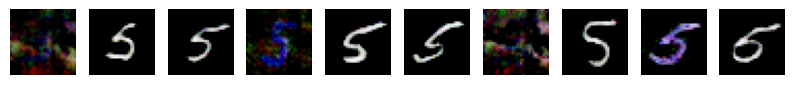

In [33]:
import torch
import matplotlib.pyplot as plt

# Set the generator to evaluation mode
netG.eval()

# Define the label for which you want to generate MNIST-M images (e.g., 5)
test_label = 5
num_samples = 10  # Number of images to generate

# Generate random noise
noise = torch.randn(num_samples, opt['nz'], 1, 1, device=device)

# Create one-hot encoding of the test label
test_label_tensor = torch.tensor([test_label] * num_samples, device=device)
test_label_one_hot = torch.nn.functional.one_hot(test_label_tensor, opt['num_classes']).type(torch.float).to(device)
test_label_one_hot_gen = test_label_one_hot.unsqueeze(2).unsqueeze(3)

# Concatenate the noise and the label
noise_with_labels = torch.cat((noise, test_label_one_hot_gen), 1)

# Generate fake MNIST-M images
with torch.no_grad():  # No need to track gradients during inference
    fake_images = netG(noise_with_labels).cpu()

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    # Assuming MNIST-M images are RGB, we use transpose to convert the generated tensor to (H, W, C)
    axes[i].imshow(fake_images[i].permute(1, 2, 0))  # permute to (height, width, channels) for RGB
    axes[i].axis('off')

plt.show()

In [34]:
target_class = 5

In [35]:
from torch.autograd import Function
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradientReversalFunction.apply(x, lambda_)

In [36]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5),  # Input channels, output channels, kernel size
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.fc_features = 48 * 5 * 5  # Calculate the output size

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.fc_features)
        return x


In [37]:
class ClassClassifier(nn.Module):
    def __init__(self):
        super(ClassClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(48 * 5 * 5, 100),
            nn.ReLU(True),
            nn.Linear(100, 100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x


In [38]:
class DomainClassifier(nn.Module):
    def __init__(self, lambda_=1.0):
        super(DomainClassifier, self).__init__()
        self.lambda_ = lambda_
        self.fc = nn.Sequential(
            nn.Linear(48 * 5 * 5, 100),
            nn.ReLU(True),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        x = grad_reverse(x, self.lambda_)
        x = self.fc(x)
        return x

In [39]:
from torchsummary import summary

feature_extractor = FeatureExtractor().to(device)
class_classifier = ClassClassifier().to(device)
domain_classifier = DomainClassifier(lambda_=opt['lamda']).to(device)

feature_extractor.apply(weights_init)
class_classifier.apply(weights_init)
domain_classifier.apply(weights_init)

# print model summaries:

print("Generator Model Summary:")
summary(netG, input_size=(opt['nz'] + 10, 1, 1))

print("\nFeature Extractor Model Summary:")
summary(feature_extractor, input_size=(opt['nc'], opt['fineSize'], opt['fineSize']))

print("\nDomain Classifier Model Summary:")
summary(domain_classifier, input_size=(48 * 5 * 5,))

Generator Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         901,120
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           6,144
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 3,530,496
Trainable params: 3,530,496
Non-trainable params: 0
----------------------------------------------------------------
I

In [40]:
# freeze weights for pre trained classifier
# for param in pre_trained_classifier.parameters():
#     param.requires_grad = False

# Loss functions
classification_loss = nn.NLLLoss().to(device)
domain_loss = nn.CrossEntropyLoss().to(device)

# Optimizers
optimizer_netG = optim.Adam(netG.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))
optimizer_feature = optim.SGD(feature_extractor.parameters(), lr=opt['baseLearningRate'], momentum=0.9)
optimizer_classifier = optim.SGD(class_classifier.parameters(), lr=opt['baseLearningRate'], momentum=0.9)
optimizer_domain = optim.SGD(domain_classifier.parameters(), lr=opt['baseLearningRate'], momentum=0.9)

In [41]:
import torch.nn.functional as F


# Function to generate images of a specific class using the GAN
def generate_images_of_class(netG, class_label, batch_size):
    # Generate random noise
    noise = torch.randn(batch_size, opt['nz'], 1, 1, device=device)
    # Create one-hot class labels
    class_labels = torch.full((batch_size,), class_label, dtype=torch.long, device=device)
    one_hot_labels = F.one_hot(class_labels, num_classes=10).float()
    one_hot_labels = one_hot_labels.view(batch_size, 10, 1, 1)
    # Concatenate noise and one-hot labels
    noise_with_labels = torch.cat((noise, one_hot_labels), 1)
    # Generate images
    fake_images = netG(noise_with_labels)
    return fake_images

In [42]:
# class to get target class dataset

class MNISTClassDataset(Dataset):
    def __init__(self, train=True, transform=None, target_class=5):
        self.transform = transform
        self.data = []
        self.labels = []
        dataset = datasets.MNIST(root='./data', train=train, download=True)
        # Filter data for target_class
        indices = (dataset.targets == target_class)
        self.data = dataset.data[indices]
        self.labels = dataset.targets[indices]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        # Convert tensor to PIL Image
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label  # Label is target_class

In [27]:
mnist_class_dataset = MNISTClassDataset(train=True, transform=transform_mnist, target_class=target_class)
mnist_class_loader = DataLoader(mnist_class_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
print(f"Number of images in MNIST class {target_class} dataset: {len(mnist_class_dataset)}")

Number of images in MNIST class 5 dataset: 5421


In [43]:
import torch.nn.functional as F

target_class = 5

#for epoch in range(1, opt['niter'] + 1):
for epoch in range(1,  500):
    netG.train()
    feature_extractor.train()
    domain_classifier.train()
    class_classifier.train()
    avg_class_loss = 0
    avg_domain_loss = 0
    count = 0
    for i, (real_images, real_labels) in enumerate(mnist_class_loader):
        if real_images.size(0) != opt['batchSize']:
            continue  # Skip incomplete batch

        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        # Generate batch_size fake images of class 5
        fake_images = generate_images_of_class(netG, target_class, opt['batchSize'])

        # Combine real and fake images
        images = torch.cat((real_images, fake_images), 0)
        # Domain labels: 0 for real, 1 for fake
        domain_labels = torch.cat((torch.zeros(opt['batchSize'], dtype=torch.long),
                                   torch.ones(opt['batchSize'], dtype=torch.long)), 0).to(device)

        # Pass images through Feature Extractor
        features = feature_extractor(images)

        # Classification loss (only for real images)
        real_features = features[:opt['batchSize']]          # features of real images
        class_outputs = class_classifier(real_features)
        class_loss = classification_loss(class_outputs, real_labels)

        # Domain classification loss
        domain_outputs = domain_classifier(features)
        dom_loss = domain_loss(domain_outputs, domain_labels)

        # Backpropagation
        optimizer_feature.zero_grad()
        optimizer_classifier.zero_grad()
        optimizer_domain.zero_grad()
        optimizer_netG.zero_grad()  # Zero gradients for netG

        # Compute total loss
        total_loss = class_loss + dom_loss

        # Backward pass
        total_loss.backward()

        # Update weights
        optimizer_feature.step()
        optimizer_classifier.step()
        optimizer_domain.step()
        optimizer_netG.step()  # Update netG's weights

        avg_class_loss += class_loss.item()
        avg_domain_loss += dom_loss.item()
        count += 1

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{opt['niter']}], Batch [{i}/{len(mnist_class_loader)}], "
                  f'Class Loss: {class_loss.item():.4f}, Domain Loss: {dom_loss.item():.4f}')

    avg_class_loss /= count
    avg_domain_loss /= count
    print(f"Epoch [{epoch}/{opt['niter']}], Avg Class Loss: {avg_class_loss:.4f}, Avg Domain Loss: {avg_domain_loss:.4f}")


Epoch [1/10000], Batch [0/85], Class Loss: 2.3021, Domain Loss: 0.6935
Epoch [1/10000], Avg Class Loss: 2.2409, Avg Domain Loss: 0.7108
Epoch [2/10000], Batch [0/85], Class Loss: 2.1661, Domain Loss: 0.7243
Epoch [2/10000], Avg Class Loss: 2.0929, Avg Domain Loss: 0.7187
Epoch [3/10000], Batch [0/85], Class Loss: 2.0189, Domain Loss: 0.7099
Epoch [3/10000], Avg Class Loss: 1.9483, Avg Domain Loss: 0.7029
Epoch [4/10000], Batch [0/85], Class Loss: 1.8770, Domain Loss: 0.6988
Epoch [4/10000], Avg Class Loss: 1.8088, Avg Domain Loss: 0.6979
Epoch [5/10000], Batch [0/85], Class Loss: 1.7398, Domain Loss: 0.6973
Epoch [5/10000], Avg Class Loss: 1.6738, Avg Domain Loss: 0.6987
Epoch [6/10000], Batch [0/85], Class Loss: 1.6069, Domain Loss: 0.7017
Epoch [6/10000], Avg Class Loss: 1.5420, Avg Domain Loss: 0.6992
Epoch [7/10000], Batch [0/85], Class Loss: 1.4757, Domain Loss: 0.6986
Epoch [7/10000], Avg Class Loss: 1.4088, Avg Domain Loss: 0.6958
Epoch [8/10000], Batch [0/85], Class Loss: 1.338

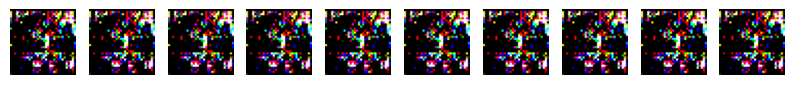

In [44]:
import torch
import matplotlib.pyplot as plt

# Set the generator to evaluation mode
netG.eval()

# Define the label for which you want to generate MNIST-M images (e.g., 5)
test_label = 5
num_samples = 10  # Number of images to generate

# Generate random noise
noise = torch.randn(num_samples, opt['nz'], 1, 1, device=device)

# Create one-hot encoding of the test label
test_label_tensor = torch.tensor([test_label] * num_samples, device=device)
test_label_one_hot = torch.nn.functional.one_hot(test_label_tensor, opt['num_classes']).type(torch.float).to(device)
test_label_one_hot_gen = test_label_one_hot.unsqueeze(2).unsqueeze(3)

# Concatenate the noise and the label
noise_with_labels = torch.cat((noise, test_label_one_hot_gen), 1)

# Generate fake MNIST-M images
with torch.no_grad():  # No need to track gradients during inference
    fake_images = netG(noise_with_labels).cpu()

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    # Assuming MNIST-M images are RGB, we use transpose to convert the generated tensor to (H, W, C)
    axes[i].imshow(fake_images[i].permute(1, 2, 0))  # permute to (height, width, channels) for RGB
    axes[i].axis('off')

plt.show()